# CenterNet (Objects as Points) 3D Car Detection Demo

This is a [CenterNet (Objects as Points)](https://arxiv.org/abs/1904.07850) colab notebook using [xingyizhou/CenterNet](https://github.com/xingyizhou/CenterNet).


For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install CenterNet

In [0]:
!pip install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html

import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/xingyizhou/CenterNet.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone
  !git clone -q --depth 1 $git_repo_url
  # fix DCNv2
  !cd {project_name}/src/lib/models/networks && rm -rf DCNv2 && git clone https://github.com/CharlesShang/DCNv2.git && cd DCNv2 && ./make.sh
  # dependencies
  !cd $project_name && pip install -q -r requirements.txt

import sys
sys.path.insert(0, join(project_name, 'src/lib'))
sys.path.append(join(project_name, 'src'))
# following 2 lines needed to avoid later import error
sys.path.append(join(project_name, 'src/lib/models/networks/DCNv2'))
from dcn_v2 import DCN

import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import clear_output

## Download a pretrained weight

We are going to use the Kitti trained model `ddd_3dop`:

|Model       |GPUs|Train time|Test time|AP-E|AP-M|AP-H|AOS-E|AOS-M|AOS-H|BEV-E|BEV-M|BEV-H| Download |
|------------|----|----------|---------|----|----|----|-----|-----|-----|-----|-----|-----|----------|
|[ddd_3dop](../experiments/ddd_3dop.sh)|2   | 7h       |  31ms   |96.9|87.8|79.2|93.9 |84.3 |75.7 |34.0 |30.5 |26.8 | [model](https://drive.google.com/open?id=1znsM6E-aVTkATreDuUVxoU0ajL1az8rz)|

In [0]:
model_name = 'ddd_3dop.pth'
if not exists(model_name):
  !pip install -q --upgrade gdown
  !gdown 'https://drive.google.com/uc?id=1znsM6E-aVTkATreDuUVxoU0ajL1az8rz'

## Initialize CenterNet for 3D

In [0]:
from opts import opts
from detectors.detector_factory import detector_factory

# CenterNet opts want argv, so overwrite it
import sys
sys.argv = ['centernet', 'ddd']
opt = opts().init()
opt.load_model = model_name
opt.exp_id='3dop'
opt.debug = 1

Detector = detector_factory[opt.task]
detector = Detector(opt)


def imshow(title, bgr_img):
  plt.figure(figsize=(20,10))
  plt.imshow(bgr_img[:,:,::-1])

# patch cv2.imshow
import cv2
cv2.imshow = imshow

## Evaluate on a Kitti test image

We will try out on a Kitti test image:

--2019-11-22 12:06:11--  https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/kitti_005064.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 766030 (748K) [image/png]
Saving to: ‘kitti_test.png’

kitti_test.png      100%[===================>] 748.08K  --.-KB/s    in 0.02s   

2019-11-22 12:06:12 (33.5 MB/s) - ‘kitti_test.png’ saved [766030/766030]



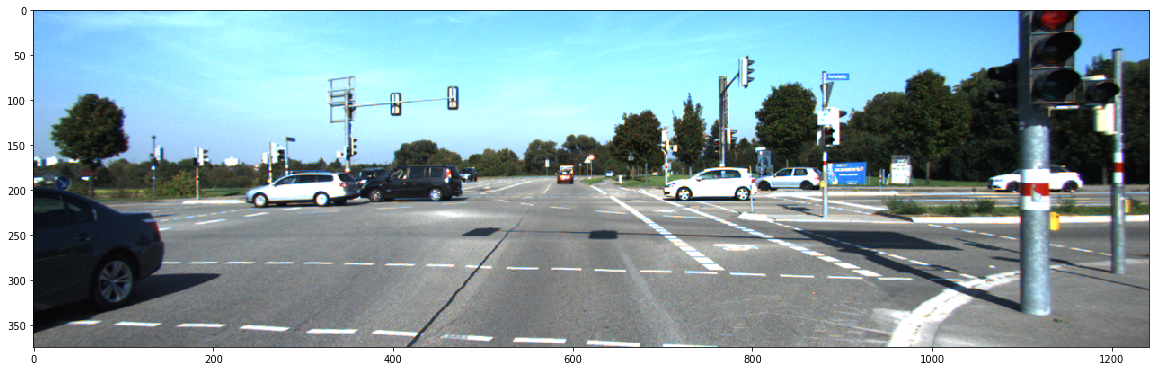

In [4]:
!wget -O kitti_test.png https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/kitti_005064.png
img = cv2.imread('kitti_test.png')
imshow('', img)

Now, test the CenterNet on the above image:

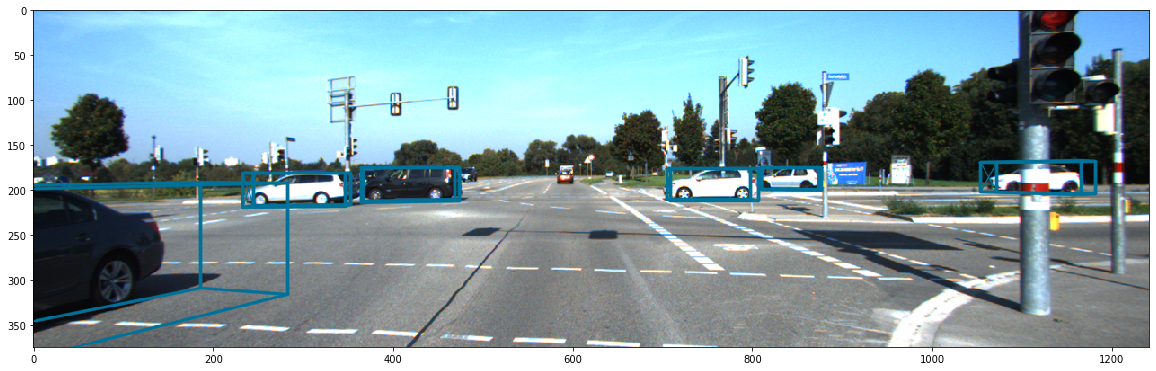

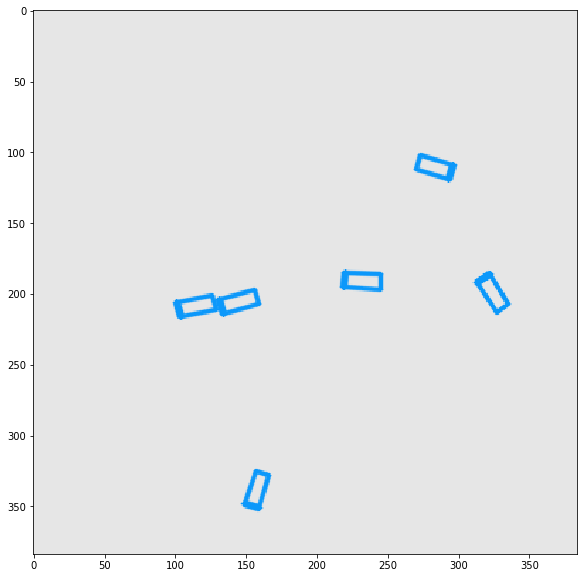

In [5]:
ret = detector.run(img)